ASOS — High-performance threshold (pop_proxy quartile3): 885.000
Class balance: 0.253
Using 4 features: ['category', 'color', 'price', 'size'] ...

=== Random Forest — Holdout ===
Accuracy : 0.761
Precision: 0.825
Recall   : 0.067
F1-score : 0.125
ROC-AUC  : 0.519

Confusion matrix (rows=true, cols=pred):
[[4536   22]
 [1439  104]]


Classification report:
              precision    recall  f1-score   support

           0      0.759     0.995     0.861      4558
           1      0.825     0.067     0.125      1543

    accuracy                          0.761      6101
   macro avg      0.792     0.531     0.493      6101
weighted avg      0.776     0.761     0.675      6101


=== Decision Tree — Holdout ===
Accuracy : 0.751
Precision: 0.576
Recall   : 0.062
F1-score : 0.111
ROC-AUC  : 0.500

Confusion matrix (rows=true, cols=pred):
[[4488   70]
 [1448   95]]


Classification report:
              precision    recall  f1-score   support

           0      0.756     0.985     0.855    

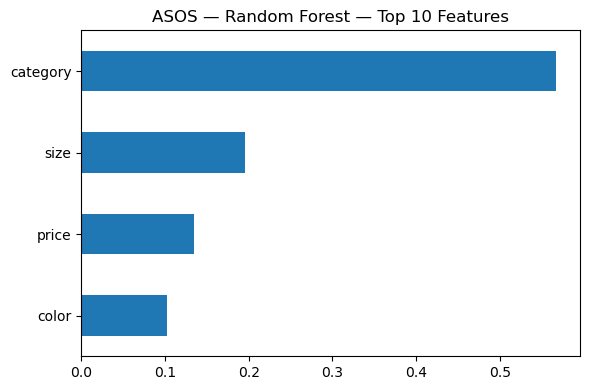

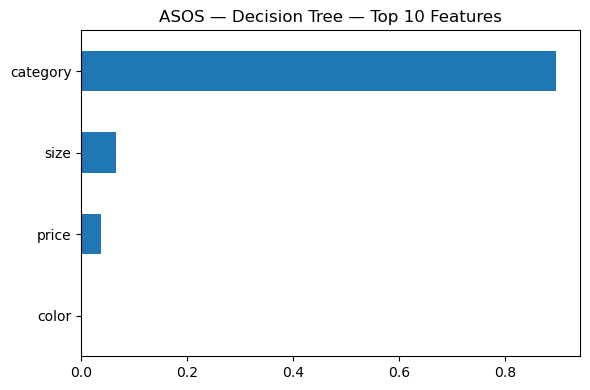

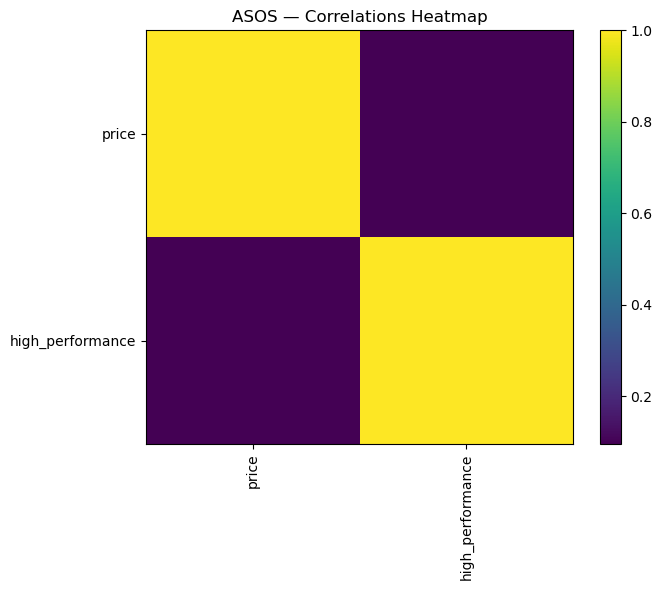

In [1]:
#======================================ASOS=========================================

# In the below lines of code, we are importing the required libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)


# Here, we are loading the files form the local system.
ASOS_product_file = r"C:\\Users\\ROHIT PAUL\\Desktop\\Dissertation Dataset\\ASOS Products.csv"   
ASOS_review_file = r"C:\\Users\\ROHIT PAUL\\Desktop\\Dissertation Dataset\\ASOS Reviews.csv"    

# A method is created to read the csv file if the text encoding is unusual.
# An error message is triggered if the file is missing.
def read_csv_file(path):
    p = Path(path)
    if not p.exists(): # In this line, if condition is implemented to check if the file path is incorrect or missing.
        raise FileNotFoundError(f"File not found: {path}")
    for enc in ["utf-8", "utf-8-sig", "latin-1"]: # In this line, common text encoding is tried to avoid read errors.
        try:
            return pd.read_csv(p, encoding=enc)
        except Exception:
            continue
    return pd.read_csv(p)

# In the below block of code, we are loading the products and droping any column which is completely empty.
products = read_csv_file(ASOS_product_file).dropna(axis=1, how="all").copy()
try:
    rev = read_csv_file(ASOS_review_file).dropna(axis=1, how="all").copy()
except Exception:
    rev = None

# The below snippet standardizes column names to lowercase_with_underscores.
products.columns = [c.strip().lower().replace(" ", "_") for c in products.columns]
if rev is not None:
    rev.columns = [c.strip().lower().replace(" ", "_") for c in rev.columns] # This line continue with the reviews even if the review files can't be read.

# Basic engineering text lengths 
if "description" in products.columns: # If condition is implemented to check if description column is present.
    products["desc_len"] = products["description"].astype(str).str.len() # This line of code captures the length of the product description.
if "name" in products.columns:
    products["name_len"] = products["name"].astype(str).str.len()  # This line of code captures the length of the product name.

# The below piece of code checks if the price is a numeric value.
if "price" in products.columns:
    products["price"] = pd.to_numeric(products["price"], errors="coerce")

# The below piece of code reviews aggregate 
join_candidates_01 = [    # A variable is defined for review aggragate.
    "product_id","productid","product_code","productcode","stock_keeping_unit",
    "sku","id","item_id","style_id","styleid","product_reference_id"
]
# In the below line, a vaible is defined to pick the first column that is present in both the datasets to join.
joining_key_01 = next((k for k in join_candidates_01 if (k in products.columns and rev is not None and k in rev.columns)), None)

# The below piece of code tries to find a numerical rating column in the reviews.
rating_columns = None
if rev is not None:
    # Try to find a numeric rating in reviews
    cand = [c for c in rev.columns if any(k in c for k in ["rating","stars","score"])]
    for c in cand:
        s = pd.to_numeric(rev[c], errors="coerce") # This line tries to convert to number.
        if s.notna().sum() > 0: # This line tries keep the first rating-like column that has numeric value.
            rev[c] = s
            rating_columns = c
            break

agg = None
if rev is not None:
    # This piece of code creates a neutral sentiment if no sentiment column is found.
    if "sentiment" not in rev.columns:
        rev["sentiment"] = 0.0

    if joining_key_01 is not None:
        gb = rev.groupby(joining_key_01, dropna=False)
        agg = gb.agg(
            reviews = ("sentiment","size"), # This line checks the count of reviews.
            sentiment = ("sentiment","mean") # This line evaluates the average sentiment.
        ).reset_index()
        if rating_columns:
            agg["rating"] = gb[rating_columns].mean().values


# Here we are building popularity proxy.
dataframe = products.copy()

# In the below piece of code, we attach the review summaries to the products using the join key.
if agg is not None and joining_key_01 is not None:
    dataframe = dataframe.merge(agg, how="left", on=joining_key_01)

# The below code creates numeric review/rating/sentiment fields keeping the default values as 0.
def safe_num(d, col, default=0.0):
    if col in d.columns:
        return pd.to_numeric(d[col], errors="coerce").fillna(default).astype(float)
    return pd.Series(default, index=d.index, dtype="float64")

rating = safe_num(dataframe, "rating", default=np.nan)
if rating.notna().any():
    r_min, r_max = rating.min(), rating.max()
    if pd.notna(r_min) and pd.notna(r_max) and r_max > r_min:
        dataframe["rating_n"] = (rating - r_min) / (r_max - r_min)
    else:
        dataframe["rating_n"] = 0.5
else:
    dataframe["rating_n"] = 0.5

dataframe["reviews_f"]   = safe_num(dataframe, "reviews",   0.0) # This line of code ensures that the count of reviews are numerical varaibles.
dataframe["sentiment_f"] = safe_num(dataframe, "sentiment", 0.0) # This line of code ensures that sentiments are numerical varaibles.

# the below code builds a single 'popularity poxy' number for each product from reviews/sentiments.
dataframe["pop_proxy"] = (dataframe["reviews_f"] + 1.0) * (dataframe["rating_n"] + 0.1) * (dataframe["sentiment_f"] + 1.0)

# Fallback to text richness if no review/rating/sentiment signal at all.
fallback_used = False
if dataframe["reviews_f"].eq(0).all() and dataframe["rating_n"].eq(0.5).all() and dataframe["sentiment_f"].eq(0).all():
    if "desc_len" in dataframe.columns or "name_len" in dataframe.columns:
        dataframe["pop_proxy"] = dataframe.get("desc_len", 0).fillna(0) + dataframe.get("name_len", 0).fillna(0)
        fallback_used = True

# Target = top quartile of popularity proxy
quartile3 = dataframe["pop_proxy"].quantile(0.75)
dataframe["high_performance"] = (dataframe["pop_proxy"] >= quartile3).astype(int)
print(f"ASOS — High-performance threshold (pop_proxy quartile3): {quartile3:.3f}")
print("Class balance:", dataframe["high_performance"].mean().round(3))

# The below block of code is about building feature list 
feature_lists = {
    "price","category","product_category","sub_category","section","department",
    "brand","gender","age_group","collection","season",
    "color","size","material","fabric","fit","style","pattern","length","occasion",
    "desc_len","name_len"  
}

# A variable is created in the below line which drops column which should not be useed in the model.
ban_list_b = re.compile(r"(review|rating|star|sentiment|helpful|vote|recommend|url|link|image|img|photo|uuid|guid|barcode|qr|timestamp|created|updated|^id$|^id_|_id$|sku)", re.I)

# Starting from all the columns except the target and computed labels. 
candidates_list = [c for c in dataframe.columns if c not in ["high_performance","pop_proxy","reviews_f","rating_n","sentiment_f","rating","reviews","sentiment"]]
# The below code removes anything that matches from the banned list.
candidates_list = [c for c in candidates_list if not ban_list_b.search(c)]

# Keep only columns that look like our hinted product-page fields or include those tokens
def method_matches_hint(col):
    if col in feature_lists:
        return True
    for h in feature_lists:
        if h in col:
            return True
    return False

relevant_features = [c for c in candidates_list if method_matches_hint(c) and dataframe[c].nunique(dropna=True) > 1]

# If we used fallback label, dropping those from features to avoid leakGE.
if fallback_used:
    relevant_features = [c for c in relevant_features if c not in {"desc_len","name_len"}]
    
# The below line of code gets triggered if nothing made through.
if not relevant_features:
    raise ValueError("No relevant product-page features detected after leakage guard.")

print(f"Using {len(relevant_features)} features:", sorted(relevant_features)[:12], "...") # This line of the code displays few feature names.


# Train/test split
# Input features.
X = dataframe[relevant_features].copy()
# Output labels.
y = dataframe["high_performance"].astype(int).values

# In the below piece of code, we split the data into test (80%) and train (20%) while keeping a balanced class proportions.
X_train_01, X_test_01, y_train_01, y_test_01 = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# The below piece of code identifies the column types/
numerical_columns = [c for c in X_train_01.columns if pd.api.types.is_numeric_dtype(X_train_01[c])] # A variable is defined in this line to have the numerical columns.
categorical_columns = [c for c in X_train_01.columns if c not in numerical_columns] # A variable is defined in this line to have the categorical columns.

# Preprocessor: fit ONLY on training data inside the Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")), # This line of the code fills any missing numerical value with the median.
        ]), numerical_columns),
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")), # This lone of the code fills missing categories with the most common value.
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)), # This line of the code turns categories into numbers.
        ]), categorical_columns),
    ],
    remainder="drop"
)


# Random Forest Modelling.
# The block of code below performs pre-processing and trains the model of 500 trees.
random_forest = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=500, # This is the number of trees.
        random_state=42, # This is the reproducible results.
        class_weight="balanced_subsample", # This line of the code hlps with the class imbalance.
        n_jobs=-1
    ))
])

# This block of the code implements the benchmark Decision TreeModel.
decision_tree = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=6, # This kine defines a depth limit to avoid over-fitting.
        random_state=42, # Reproducible results.
        class_weight="balanced" # This line of the code handles class imbalance.
    ))
])

# Fit & evaluate on the holdput performance.
random_forest.fit(X_train_01, y_train_01) # In this line, we are traininig the Random Forest model.
decision_tree.fit(X_train_01, y_train_01) # In this line, we are traininig the Decision Tree model.

# Below, a method is defined to make predictions on test set and print a standard performance metrics.
# Also prints the confusion matrix and a classification report.
def method_evaluation_model(name, pipe, Xt, yt):
    y_hat_01 = pipe.predict(Xt)
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob_01 = pipe.predict_proba(Xt)[:, 1]
    else:
        # fallback if predict_proba not available
        y_prob_01 = pipe.decision_function(Xt)
        # scale to 0-1
        y_prob_01 = (y_prob_01 - y_prob_01.min()) / (y_prob_01.max() - y_prob_01.min() + 1e-9)

# Below are the features of the standard metrics.
    accuracy  = accuracy_score(yt, y_hat_01) # This line of the code evaluates accuracy value of the model.
    precision = precision_score(yt, y_hat_01, zero_division=0) # This line of the code evaluates precision value of the model.
    recall  = recall_score(yt, y_hat_01, zero_division=0) # This line of the code evaluates recall value of the model.
    f1   = f1_score(yt, y_hat_01, zero_division=0) # This line of the code evaluates F1-score of the model.
    auc  = roc_auc_score(yt, y_prob_01) # This line of the code evaluates ROC-AUc value of the model.

# The below lines of code prints the features of the model.    
    print(f"\n=== {name} — Holdout ===")
    print(f"Accuracy : {accuracy:.3f}") # This line of the code prints accuracy value of the model.
    print(f"Precision: {precision:.3f}") # This line of the code prints precision value of the model.
    print(f"Recall   : {recall:.3f}") # This line of the code prints recall value of the model.
    print(f"F1-score : {f1:.3f}") # This line of the code prints F1-score of the model.
    print(f"ROC-AUC  : {auc:.3f}") # This line of the code prints ROC-AUUC value of the model.
    print() # This inserts a blank line.
    print("Confusion matrix (rows=true, cols=pred):") 
    print(confusion_matrix(yt, y_hat_01)) # This line displays the confusion matrix.
    print() # This inserts a blank line.
    print("\nClassification report:")
    print(classification_report(yt, y_hat_01, digits=3))  # This line displays the classification report.

# The below line of code evaluates both the models on hold-out performance.
method_evaluation_model("Random Forest", random_forest, X_test_01, y_test_01) # This is for the Random Forest model.
method_evaluation_model("Decision Tree", decision_tree, X_test_01, y_test_01) # This is for the Decision Tree model.
 
# The below block of code cross-validates ROC-AUC.
# Here we are splitting the data into 5 parts repeatedly to estimate the performance stability.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_auc = cross_val_score(random_forest, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
dt_cv_auc = cross_val_score(decision_tree, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print("\nRF — CV ROC-AUC (mean ± sd): %.3f ± %.3f" % (rf_cv_auc.mean(), rf_cv_auc.std()))
print("DT — CV ROC-AUC (mean ± sd): %.3f ± %.3f" % (dt_cv_auc.mean(), dt_cv_auc.std()))

# Feature Importance Analysis.
def method_feature_names(numerical_columns, categorical_columns):
    return list(numerical_columns) + list(categorical_columns)

# A method is defined to plot the top 10 features if model can explain which eatures matter the most.
def method_feature_importances(pipe, title):
    clf = pipe.named_steps["clf"]
    if not hasattr(clf, "feature_importances_"):
        print(f"{title}: classifier has no feature_importances_.")
        return
    # Build the training preprocessor to learn column order
    prep = pipe.named_steps["prep"]
    prep.fit(X_train_01, y_train_01)
    var_feat_names = method_feature_names(numerical_columns, categorical_columns)
# In the below line, a variable is declared to create a ranked list of importance values labeled by feature names.
    imps = pd.Series(clf.feature_importances_, index=var_feat_names).sort_values(ascending=False)
    v_top10 = imps.head(10).iloc[::-1]
    v_top10.plot.barh(figsize=(6,4)) # This line of the code plots the bar chart.
    plt.title(title + " — Top 10 Features")
    plt.tight_layout()
    plt.show() # This line of the code displays the plot.
    return imps

# The below lines of codes are plots for both the models.
v_rforest_imps = method_feature_importances(random_forest, "ASOS — Random Forest")
v_dtree_imps = method_feature_importances(decision_tree, "ASOS — Decision Tree")


# Correlation heatmap is created in the below lines of code.
x_corr_dataframe = pd.concat([X[numerical_columns], pd.Series(y, name="high_performance", index=X.index)], axis=1) if numerical_columns else None
if x_corr_dataframe is not None and x_corr_dataframe.shape[1] >= 2:
    x_corr_01 = x_corr_dataframe.corr() # In this line, we are evaluating the correlation matrix.
    plt.figure(figsize=(7,6))
    im = plt.imshow(x_corr_01, aspect="auto")
    plt.title("ASOS — Correlations Heatmap")
    plt.xticks(range(len(x_corr_01.columns)), x_corr_01.columns, rotation=90) # This line labesl the X-axis.
    plt.yticks(range(len(x_corr_01.index)), x_corr_01.index) # This line labesl the Y-axis.
    plt.colorbar(im) # This line adds a colour bar for reference.
    plt.tight_layout()
    plt.show() # This line of the code displays the heatmap generated.
